In [1]:
# Carga de librerías
import numpy as np
import tensorflow as tf
import PIL
import PIL.Image
import pathlib
import scipy as sp
import seaborn as sns
from itertools import product
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Conv2D, Dense, MaxPooling2D, Lambda
from tensorflow.keras import backend as K
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib.collections import LineCollection
from matplotlib.font_manager import FontProperties

from numpy.linalg import LinAlgError
from scipy.sparse.csgraph import laplacian
# from spectral_metric.lib import find_samples, compute_expectation_with_monter_carlo 
from spectral_metric.estimator import CumulativeGradientEstimator
from spectral_metric.visualize import make_graph

In [3]:
# Lectura de dataset

data_dir = ('MNIST')

# Lectura de la carpeta train
data_dir_train = ('MNIST/train')
data_dir_train = pathlib.Path(data_dir_train)

# Lectura de la carpeta test
data_dir_test = ('MNIST/test')
data_dir_test = pathlib.Path(data_dir_test)

# data_dir_train = Path('Dataset/train') # Lectura de la carpeta train
# data_dir_test = Path('Dataset/test') # Lectura de la carpeta test

image_count_train = len(list(data_dir_train.glob('*/*.png')))  # Cuenta la cantidad de imagenes de train
image_count_test = len(list(data_dir_test.glob('*/*.png')))    # Cuenta la cantidad de imagenes de test

image_count_glob = image_count_train + image_count_test

print(f"Cantidad de imagenes de train: {image_count_train}")
print(f"Cantidad de imagenes de test: {image_count_test}")
print(f"Cantidad de imagenes del dataset: {image_count_glob}")

Cantidad de imagenes de train: 60000
Cantidad de imagenes de test: 10000
Cantidad de imagenes del dataset: 70000


In [4]:
img_height = 28
img_width = 28
batch_s = 32

In [5]:
train_datagen = ImageDataGenerator(
    #width_shift_range=[0.2],     # Desplazamiento horizontal
    #height_shift_range=[0.2],    # Desplazamiento vertical
    #horizontal_flip=True,        # Efecto espejo horizontal
    #vertical_flip=True,          # Efecto espejo vertical
    #rotation_range=45,           # Rotación
    #samplewise_std_normalization=True,   # Normalización
    #brightness_range=(0.25, 0.75),       # Brillo
    #channel_shift_range=115.3,           # Desplazamiento de canal
    #shear_range=40, fill_mode='constant', # Angulo de corte
    #rescale = 1./255,  # Para el caso de MNIST, las imagenes de este dataset vienen por defecto normalizadas en el rangoi de 0 a 1m por lo tanto no es necesario activar esta acción aquí
    #zoom_range=0.2,
    validation_split=0.2
)

In [6]:
train_generator = train_datagen.flow_from_directory(
        #'Dataset/train',
        data_dir_train,
        target_size = (img_height, img_width),
        batch_size = batch_s,
        #batch_size = image_count_train,
        #class_mode = 'categorical',
        class_mode = 'sparse',
        #subset = 'training'
)

val_generator = train_datagen.flow_from_directory(
        #'Dataset/test',
        data_dir_test,
        target_size = (img_height, img_width),
        batch_size = batch_s,
        #batch_size = image_count_test,
        #class_mode = 'categorical',
        class_mode = 'sparse',
        #subset = 'validation'
)

Found 60000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


In [7]:
# class_names = train_generator.class_names
class_names = list(train_generator.class_indices.keys())   # Get the name of the classes
num_classes = len(class_names)  # get the number of the classes
print(f"Número de clases: {num_classes}")
print(f"Los nombres de las clases son: {class_names}")

Número de clases: 10
Los nombres de las clases son: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [8]:
import random 
from pathlib import Path
from IPython.display import display, Markdown

# Lista para almacenar los directorios de las imágenes de train y test
train_directories = [data_dir_train / str(i) for i in range(10)]
test_directories = [data_dir_test / str(i) for i in range(10)]


# Inicializar una lista vacía para almacenar las listas de imágenes por clase
train_image_lists = []
test_image_lists = []

# Iterar sobre el rango de clases (0-9)
for i in range(num_classes):
    # Obtener el directorio de la clase para train y test
    train_dir = data_dir_train / str(i)
    test_dir = data_dir_test / str(i)
    
    # Listar todas las imágenes de train para esta clase
    train_images = list(train_dir.glob('*.png'))
    train_image_lists.append(train_images)
    
    # Listar todas las imágenes de test para esta clase
    test_images = list(test_dir.glob('*.png'))
    test_image_lists.append(test_images)

# Ahora train_image_lists contiene listas de imágenes para cada clase en train
# Y test_image_lists contiene listas de imágenes para cada clase en test

# Elegir una clase al azar
class_index = random.randint(0, num_classes - 1)

# Elegir una imagen al azar de la clase seleccionada en el conjunto de entrenamiento
train_class_images = train_image_lists[class_index]
train_image_path = random.choice(train_class_images)

# Mostrar la imagen seleccionada del conjunto de entrenamiento
image_train = PIL.Image.open(train_image_path)
title_train = f"Imagen de entrenamiento (Clase {class_index})"
display(Markdown(f"### {title_train}"))
#image_train.show()  # Muestra la imagen en una ventana emergente
display(image_train)

# Elegir una imagen al azar de la clase seleccionada en el conjunto de prueba
test_class_images = test_image_lists[class_index]
test_image_path = random.choice(test_class_images)

# Mostrar la imagen seleccionada del conjunto de prueba
image_test = PIL.Image.open(test_image_path)
title_test = f"Imagen de prueba (Clase {class_index})"
display(Markdown(f"### {title_test}"))
#image_test.show()   # Muestra la imagen en una ventana emergente
display(image_test)


"""
# Directorio para las imágenes de train
data_dir_train_0 = Path("MNIST/train/0")
data_dir_train_1 = Path("MNIST/train/1")
data_dir_train_2 = Path("MNIST/train/2")
data_dir_train_3 = Path("MNIST/train/3")
data_dir_train_4 = Path("MNIST/train/4")
data_dir_train_5 = Path("MNIST/train/5")
data_dir_train_6 = Path("MNIST/train/6")
data_dir_train_7 = Path("MNIST/train/7")
data_dir_train_8 = Path("MNIST/train/8")
data_dir_train_9 = Path("MNIST/train/9")


# Directorio para las imágenes de test
data_dir_test_0 = Path("MNIST/test/0")
data_dir_test_1 = Path("MNIST/test/1")
data_dir_test_2 = Path("MNIST/test/2")
data_dir_test_3 = Path("MNIST/test/3")
data_dir_test_4 = Path("MNIST/test/4")
data_dir_test_5 = Path("MNIST/test/5")
data_dir_test_6 = Path("MNIST/test/6")
data_dir_test_7 = Path("MNIST/test/7")
data_dir_test_8 = Path("MNIST/test/8")
data_dir_test_9 = Path("MNIST/test/9")
"""

"""
# Listar todas las imagenes de train por clase
A_train_0 = list(data_dir_train_0.glob('*.png'))  # Name of the class 0 into train
A_train_1 = list(data_dir_train_1.glob('*.png'))  # Name of the class 1 into train
A_train_2 = list(data_dir_train_2.glob('*.png'))  # Name of the class 2 into train
A_train_3 = list(data_dir_train_3.glob('*.png'))  # Name of the class 3 into train
A_train_4 = list(data_dir_train_4.glob('*.png'))  # Name of the class 4 into train
A_train_5 = list(data_dir_train_5.glob('*.png'))  # Name of the class 5 into train
A_train_6 = list(data_dir_train_6.glob('*.png'))  # Name of the class 6 into train
A_train_7 = list(data_dir_train_7.glob('*.png'))  # Name of the class 7 into train
A_train_8 = list(data_dir_train_8.glob('*.png'))  # Name of the class 8 into train
A_train_9 = list(data_dir_train_9.glob('*.png'))  # Name of the class 9 into train

# Listar todas las imagenes de test por clase
A_test_0 = list(data_dir_test_0.glob('*.png'))  # Name of the class 0 into test
A_test_1 = list(data_dir_test_1.glob('*.png'))  # Name of the class 1 into test
A_test_2 = list(data_dir_test_2.glob('*.png'))  # Name of the class 2 into test
A_test_3 = list(data_dir_test_3.glob('*.png'))  # Name of the class 3 into test
A_test_4 = list(data_dir_test_4.glob('*.png'))  # Name of the class 4 into test
A_test_5 = list(data_dir_test_5.glob('*.png'))  # Name of the class 5 into test
A_test_6 = list(data_dir_test_6.glob('*.png'))  # Name of the class 6 into test
A_test_7 = list(data_dir_test_7.glob('*.png'))  # Name of the class 7 into test
A_test_8 = list(data_dir_test_8.glob('*.png'))  # Name of the class 8 into test
A_test_9 = list(data_dir_test_9.glob('*.png'))  # Name of the class 9 into test
"""

"""
# PIL.Image.open(str(A_train_0[20]))  # Mostrar una imagen dentro de la clase 0 into train
# PIL.Image.open(str(A_train_1[40]))  # Mostrar una imagen dentro de la clase 1 into train
# PIL.Image.open(str(A_train_2[20]))  # Mostrar una imagen dentro de la clase 2 into train
# PIL.Image.open(str(A_train_3[40]))  # Mostrar una imagen dentro de la clase 3 into train
# PIL.Image.open(str(A_train_4[20]))  # Mostrar una imagen dentro de la clase 4 into train
# PIL.Image.open(str(A_train_5[40]))  # Mostrar una imagen dentro de la clase 5 into train
# PIL.Image.open(str(A_train_6[20]))  # Mostrar una imagen dentro de la clase 6 into train
# PIL.Image.open(str(A_train_7[40]))  # Mostrar una imagen dentro de la clase 7 into train
# PIL.Image.open(str(A_train_8[20]))  # Mostrar una imagen dentro de la clase 8 into train
# PIL.Image.open(str(A_train_9[40]))  # Mostrar una imagen dentro de la clase 9 into train

#PIL.Image.open(str(A_test_0[20]))  # Mostrar una imagen dentro de la clase 0 into test
# PIL.Image.open(str(A_test_1[20]))  # Mostrar una imagen dentro de la clase 1 into test
# PIL.Image.open(str(A_test_2[20]))  # Mostrar una imagen dentro de la clase 2 into test
# PIL.Image.open(str(A_test_3[20]))  # Mostrar una imagen dentro de la clase 3 into test
# PIL.Image.open(str(A_test_4[20]))  # Mostrar una imagen dentro de la clase 4 into test
# PIL.Image.open(str(A_test_5[20]))  # Mostrar una imagen dentro de la clase 5 into test
# PIL.Image.open(str(A_test_6[20]))  # Mostrar una imagen dentro de la clase 6 into test
# PIL.Image.open(str(A_test_7[20]))  # Mostrar una imagen dentro de la clase 7 into test
# PIL.Image.open(str(A_test_8[20]))  # Mostrar una imagen dentro de la clase 8 into test
# PIL.Image.open(str(A_test_9[20]))  # Mostrar una imagen dentro de la clase 9 into test
"""


### Imagen de entrenamiento (Clase 7)

### Imagen de prueba (Clase 7)

'\n# PIL.Image.open(str(A_train_0[20]))  # Mostrar una imagen dentro de la clase 0 into train\n# PIL.Image.open(str(A_train_1[40]))  # Mostrar una imagen dentro de la clase 1 into train\n# PIL.Image.open(str(A_train_2[20]))  # Mostrar una imagen dentro de la clase 2 into train\n# PIL.Image.open(str(A_train_3[40]))  # Mostrar una imagen dentro de la clase 3 into train\n# PIL.Image.open(str(A_train_4[20]))  # Mostrar una imagen dentro de la clase 4 into train\n# PIL.Image.open(str(A_train_5[40]))  # Mostrar una imagen dentro de la clase 5 into train\n# PIL.Image.open(str(A_train_6[20]))  # Mostrar una imagen dentro de la clase 6 into train\n# PIL.Image.open(str(A_train_7[40]))  # Mostrar una imagen dentro de la clase 7 into train\n# PIL.Image.open(str(A_train_8[20]))  # Mostrar una imagen dentro de la clase 8 into train\n# PIL.Image.open(str(A_train_9[40]))  # Mostrar una imagen dentro de la clase 9 into train\n\n#PIL.Image.open(str(A_test_0[20]))  # Mostrar una imagen dentro de la clase

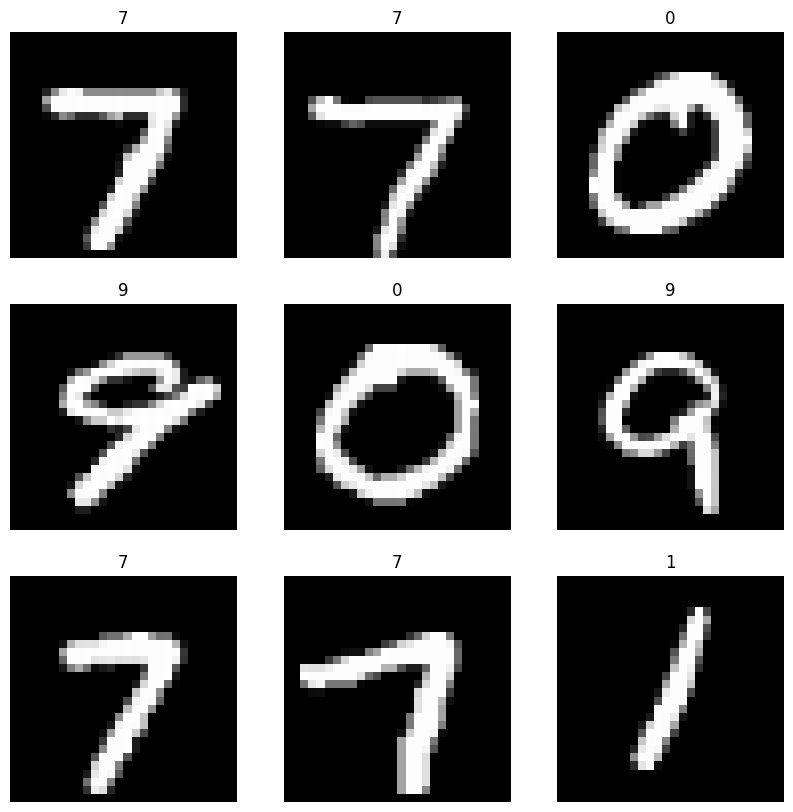

In [9]:
# Mostrar las primeras 9 imágenes del generador de entrenamiento
plt.figure(figsize=(10, 10))
for i in range(9):
    # Obtener un lote de imágenes y etiquetas del generador
    images, labels = next(train_generator)
    # Iterar sobre las imágenes en el lote
    for j in range(len(images)):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[j].astype("uint8"))
        plt.title(class_names[int(labels[j])])  # Mostrar el nombre de la clase basado en la etiqueta
        plt.axis("off")
plt.show()


In [10]:
# Aqui se toman todas las imagenes de entrenamiento y validación

train_generator_full = train_datagen.flow_from_directory(
        #'Dataset/train',
        data_dir_train,
        target_size = (img_height, img_width),
        #batch_size = batch_s,    # Toma solo 32 imagenes
        batch_size = image_count_train,   # Toma todas las imagenes
        #class_mode = 'categorical',
        class_mode = 'sparse',
        #subset = 'training'
)

val_generator_full = train_datagen.flow_from_directory(
        #'Dataset/test',
        data_dir_test,
        target_size = (img_height, img_width),
        #batch_size = batch_s,   # Toma solo 32 imagenes
        batch_size = image_count_test,   # Toma todas las imagenes
        #class_mode = 'categorical',
        class_mode = 'sparse',
        #subset = 'validation'
)

Found 60000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


In [11]:
from PIL import Image
import numpy as np
import pathlib

""" The following code is very important, here, we will convert the images dataset from RGB to Gray scale.
It is important because the CSG metric only works with 3 Dimensions arrays. If you have an array of images 
with a shape of dimensions different to 3 in where the shape in x_train and y_train must be 
{full number of images, images height, images width}, this in the case of the training set. 
In the case of labels, the array must be of 1 dimension, therefore, the shape of x_test and y_test must be 
{full number of images} """


# Definir la función para cargar y preprocesar las imágenes
def load_and_preprocess_image(image_path, target_size):
    # Cargar la imagen en color
    img = Image.open(image_path)
    
    # Convertir la imagen a escala de grises
    img_gray = img.convert('L')
    
    # Redimensionar la imagen al tamaño deseado
    img_resized = img_gray.resize(target_size)
    
    # Convertir la imagen a un arreglo numpy
    img_array = np.array(img_resized) / 255.0  # Normalizar los valores de píxel
    
    return img_array


# Tamaño de las imágenes deseado (ancho, alto)
target_size = (img_height, img_width)

# Lista para almacenar las imágenes y las etiquetas de entrenamiento
x_train = []
y_train = []


# Leer las imágenes de entrenamiento
for class_name in class_names:
    class_dir = data_dir_train / class_name
    for image_path in class_dir.glob('*.png'):
        img_array = load_and_preprocess_image(image_path, target_size)
        x_train.append(img_array)
        y_train.append(class_names.index(class_name))


# Lista para almacenar las imágenes y las etiquetas de prueba
x_test = []
y_test = []

# Leer las imágenes de prueba
for class_name in class_names:
    class_dir = data_dir_test / class_name
    for image_path in class_dir.glob('*.png'):
        img_array = load_and_preprocess_image(image_path, target_size)
        x_test.append(img_array)
        y_test.append(class_names.index(class_name))

# Convertir las listas a arreglos numpy
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)



In [12]:
# Mostrar las dimensiones del conjunto de datos

print(f"\nDimensiones del conjunto de entrenamiento:, {x_train.shape}, Número de dimensiones: {x_train.ndim}")
# Verificar las dimensiones de x_train
if x_train.ndim == 3:
    print("x_train es una matriz 3D")
else:
    print("x_train no es una matriz 3D")

print(f"\nDimensiones del conjunto de prueba: {x_test.shape}, Número de dimensiones: {x_test.ndim}")
# Verificar las dimensiones de x_test
if x_test.ndim == 3:
    print("x_test es una matriz 3D")
else:
    print("x_test no es una matriz 3D")

print(f"\nDimensiones de las etiquetas de entrenamiento: {y_train.shape}, Número de dimensiones: {y_train.ndim}")
# Verificar las dimensiones de y_train
if y_train.ndim == 1:
    print("y_train es una matriz 1D")
else:
    print("y_train no es una matriz 1D")

print(f"\nDimensiones de las etiquetas de prueba: {y_test.shape}, Número de dimensiones: {y_test.ndim}")
# Verificar las dimensiones de y_test
if y_test.ndim == 1:
    print("y_test es una matriz 1D")
else:
    print("y_test no es una matriz 1D")


Dimensiones del conjunto de entrenamiento:, (60000, 28, 28), Número de dimensiones: 3
x_train es una matriz 3D

Dimensiones del conjunto de prueba: (10000, 28, 28), Número de dimensiones: 3
x_test es una matriz 3D

Dimensiones de las etiquetas de entrenamiento: (60000,), Número de dimensiones: 1
y_train es una matriz 1D

Dimensiones de las etiquetas de prueba: (10000,), Número de dimensiones: 1
y_test es una matriz 1D


In [13]:
# Reshape the data

#X = x_train.reshape((x_train.shape[0], -1))
X = x_train.reshape((x_train.shape[0], x_train.shape[1] * x_train.shape[2]))  # Other way to reshape the array 
Y = y_train.reshape(y_train.shape[0],)   # Convert the array to 1D
print(X.shape)
print(Y.shape)

(60000, 784)
(60000,)


Dataset complexity: [0.08134457]
Dataset complexity in percentage: 8.134 %


C:\Users\Cesar\AppData\Local\Temp\ipykernel_240\2274999652.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Dataset complexity in percentage: {round(float(csg) * 100, 3)} %")
c:\Users\Cesar\Desktop\Proyecto-de-grado-CSG\1 - prueba de CSG\Pruebas en distintos datasets\spectral_metric\visualize.py:48: RuntimeWarning: divide by zero encountered in divide
  similarities = difference.max() / difference * 100
c:\Users\Cesar\Desktop\Proyecto-de-grado-CSG\1 - prueba de CSG\Pruebas en distintos datasets\spectral_metric\visualize.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


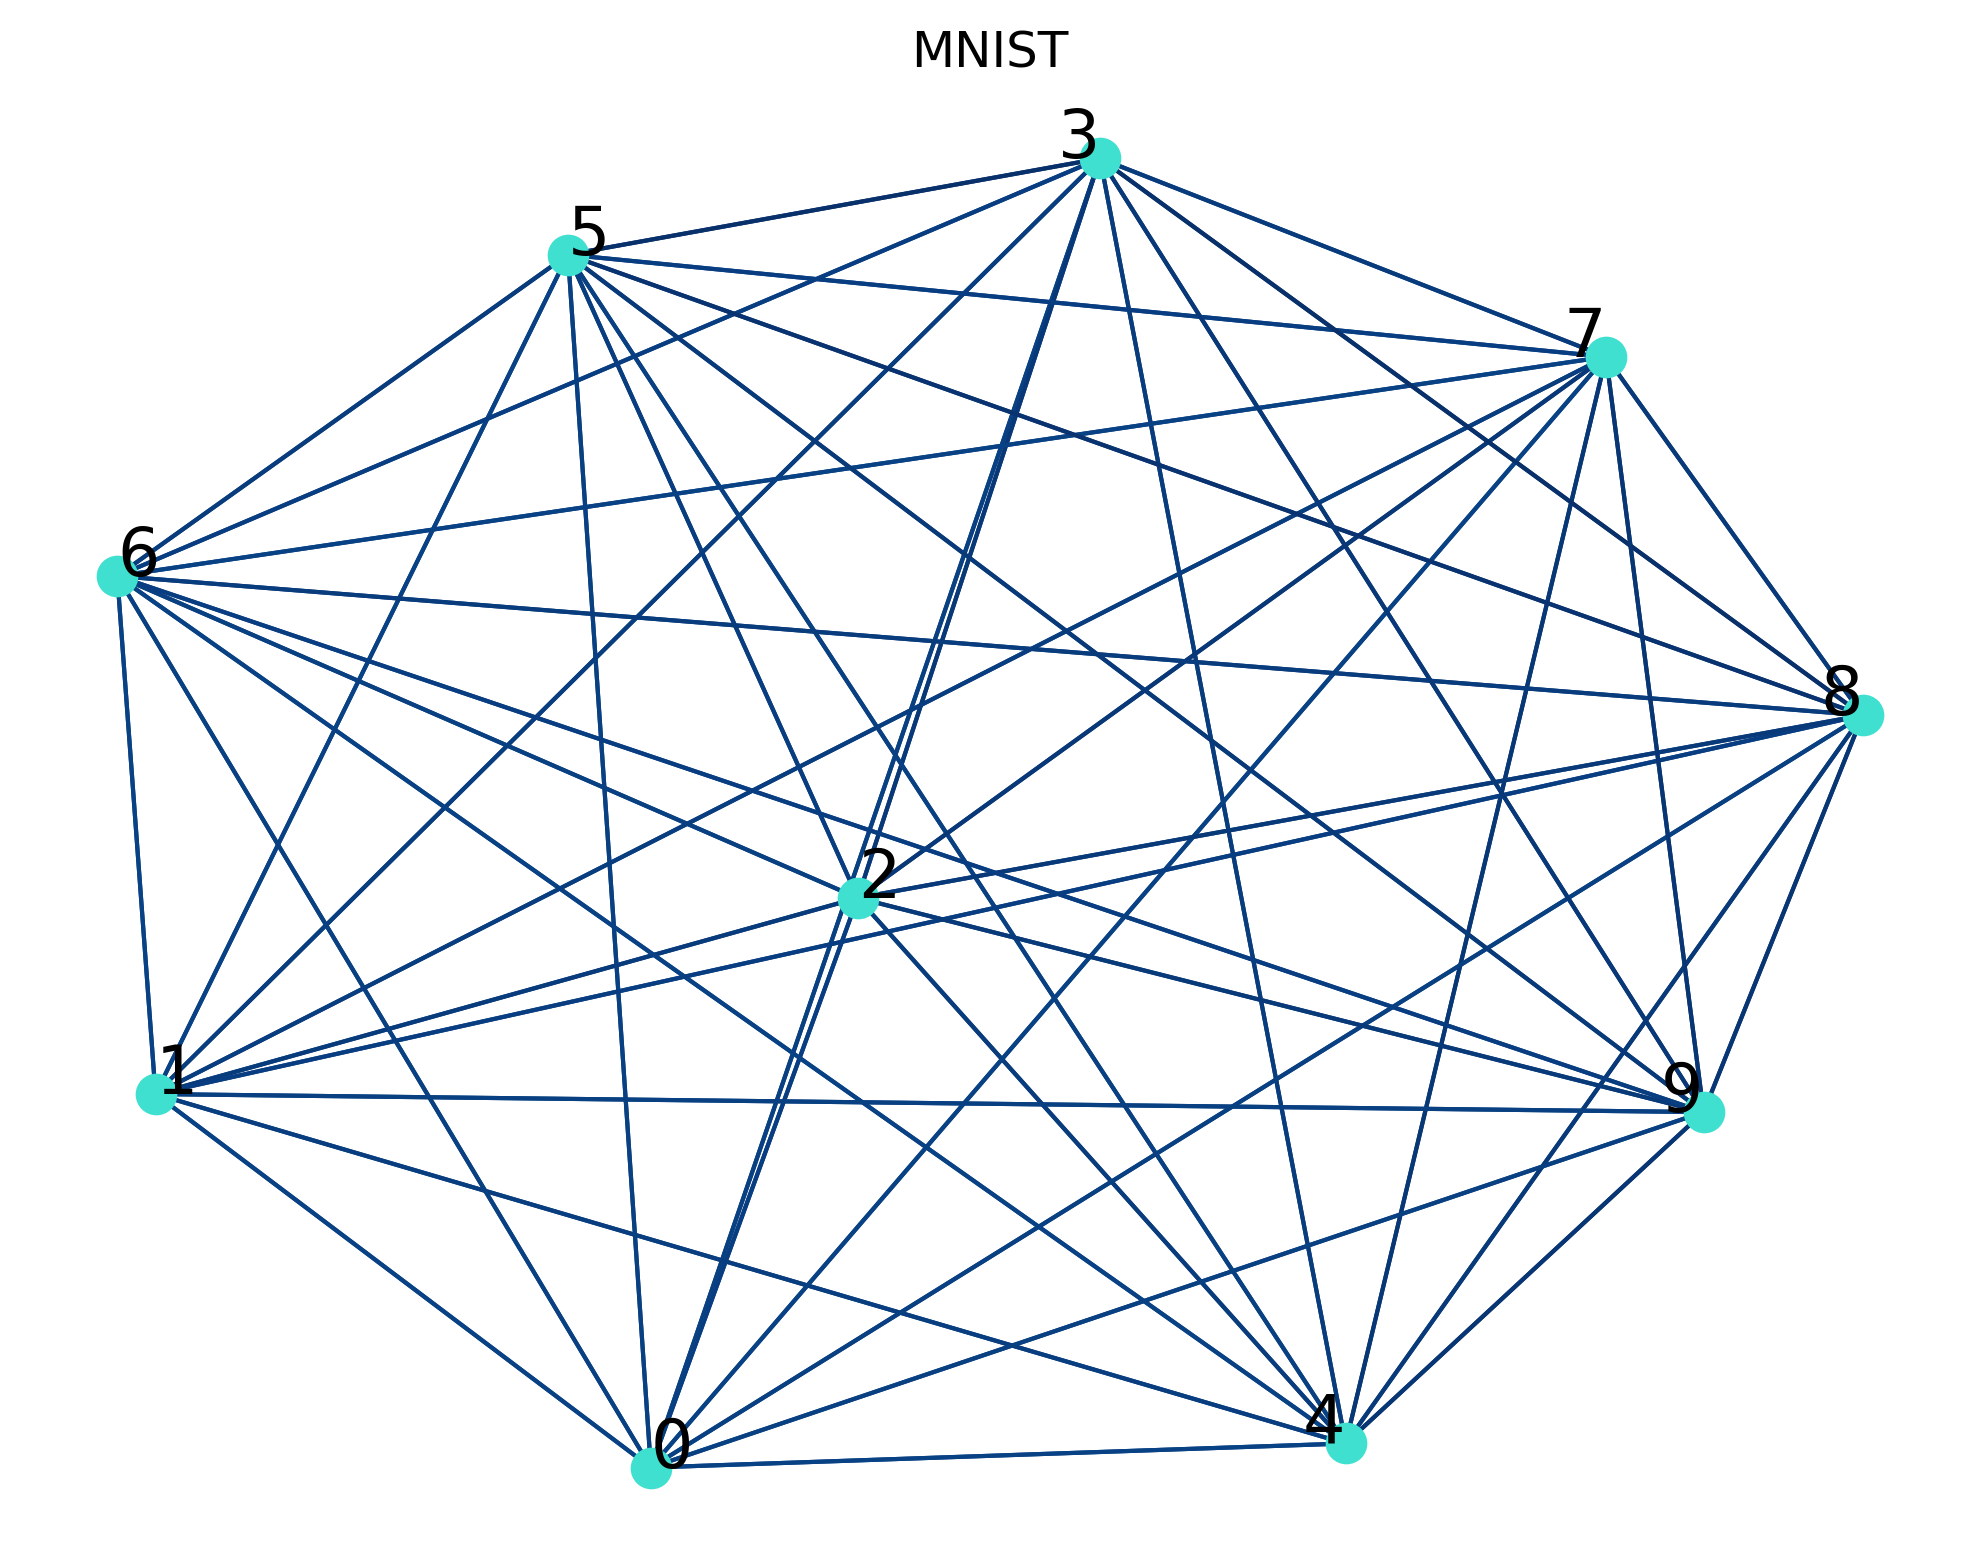

In [14]:
# Apply CSG Metric
    

estimator = CumulativeGradientEstimator(M_sample=250, k_nearest=5)
estimator.fit(data = X, target = Y)

# Obtain the complexity values
csg = estimator.csg     # The actual or real complexity values
estimator.evals, estimator.evecs     # The eigenvalues and vectors

# Complexity
print(f"Dataset complexity: {csg}")
print(f"Dataset complexity in percentage: {round(float(csg) * 100, 3)} %")

# Plot the dataset
make_graph(estimator.difference, title="MNIST", classes=[str(i) for i in range(10)])

In [15]:
# Complexity
print(f"Dataset complexity: {csg}")


Dataset complexity: [0.08134457]


In [16]:
print(f"Dataset complexity in percentage: {round(float(csg) * 100, 3)} %")

Dataset complexity in percentage: 8.134 %


C:\Users\Cesar\AppData\Local\Temp\ipykernel_240\439354336.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Dataset complexity in percentage: {round(float(csg) * 100, 3)} %")
